# Tutorial 3: Mouse_Hippocampus


## Environment Configuration & Package Loading

In [1]:
import os
import torch
import scanpy as sc
from GenOT import genot

In [2]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1'
os.environ['PATH'] = 'C:/Program Files/R/R-4.4.1/bin/x64;' + os.environ['PATH']

## Data Loading

In [3]:
file_fold = r"..\Data\Mouse_Hippocampus_Tissue.h5ad"
adata = sc.read_h5ad(file_fold)
adata = sc.pp.subsample(adata, n_obs=10000, random_state=0, copy=True)
adata.var_names_make_unique()

In [4]:
from GenOT.utils import find_hvg_somde

hvg_gene_names = find_hvg_somde(
    adata,
    save_output=False, #save txt
)

adata = adata[:, hvg_gene_names].copy()


using 22*22 SOM nodes for 10000 points
norm mtx first


Models: 100%|██████████| 10/10 [05:10<00:00, 31.05s/it][A


In [5]:
adata

AnnData object with n_obs × n_vars = 10000 × 5907
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

## Run GenOT

In [6]:
# define model
encoder = genot.Encoder(adata,epochs=1500, device=device,)

# run model
adata = encoder.train_encoder()

Begin to train ...


100%|██████████| 1500/1500 [00:25<00:00, 58.88it/s]


 finished!


## Spatial Domain Identification (mclust)

In [7]:
from GenOT.utils import clustering
# clustering
n_clusters = 12
clustering(adata, n_clusters, method='mclust')


   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## Visualization

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

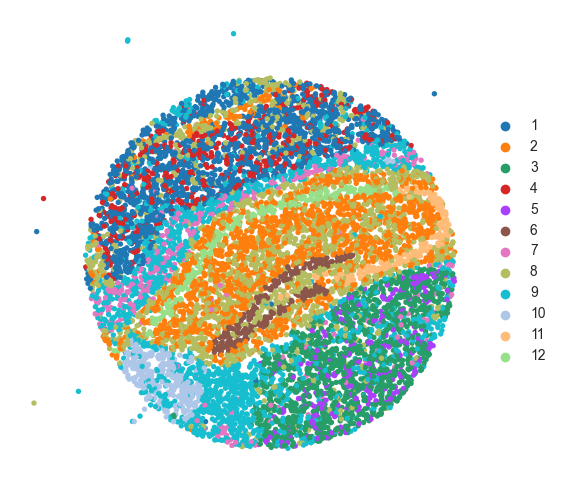

In [8]:
# plotting spatial clustering result
import matplotlib.pyplot as plt
import seaborn as sns
adata.obsm['spatial'][:,1] = -1*adata.obsm['spatial'][:,1]
rgb_values = sns.color_palette("tab10", len(adata.obs['domain'].unique()))
color_fine = dict(zip(list(adata.obs['domain'].unique()), rgb_values))

plt.rcParams["figure.figsize"] = (12, 6)
sc.pl.spatial(adata, img_key=None, color='domain',  title="",
                  show=False, frameon=False, spot_size=70)